In [163]:
import pandas as pd
import unicodedata
import string
import re
import seaborn as sns
import random

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import nltk
from nltk.util import ngrams
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import langdetect
import spacy

from sklearn.model_selection import train_test_split,cross_val_score,KFold
from sklearn.metrics import precision_recall_curve,precision_score,recall_score,accuracy_score
from sklearn.metrics import plot_confusion_matrix,plot_precision_recall_curve,plot_roc_curve
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn import feature_extraction,naive_bayes,pipeline,manifold,preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import feature_selection

from lime import lime_text
import gensim
import gensim.downloader as gensim_api

from tensorflow.keras import models,layers,preprocessing as kprocessing
from tensorflow.keras import backend as K

import transformers

import numpy as np

In [3]:
col_names = ['target','question_title','question_content','best_answer']
target_classes = ['Society & Culture','Science & Mathematics','Health','Education & Reference',
                  'Computers & Internet','Sports','Business & Finance','Entertainment & Music',
                  'Family & Relationships','Politics & Government']
target_classes_dict = {1:'Society & Culture',
                       2:'Science & Mathematics',
                       3:'Health',
                       4:'Education & Reference',
                       5:'Computers & Internet',
                       6:'Sports',
                       7:'Business & Finance',
                       8:'Entertainment & Music',
                       9:'Family & Relationships',
                       10:'Politics & Government'}

In [4]:
df = pd.read_csv('data_yahoo/train.csv',header=None,names=col_names)
# df_test = pd.read_csv('data_yahoo/test.csv',header=None,names=col_names)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400000 entries, 0 to 1399999
Data columns (total 4 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   target            1400000 non-null  int64 
 1   question_title    1400000 non-null  object
 2   question_content  768325 non-null   object
 3   best_answer       1375421 non-null  object
dtypes: int64(1), object(3)
memory usage: 42.7+ MB


In [5]:
df.head()

,target,question_title,question_content,best_answer
0,5,why doesn't an optical mouse work on a glass t...,or even on some surfaces?,Optical mice use an LED and a camera to rapidl...
1,6,What is the best off-road motorcycle trail ?,long-distance trail throughout CA,i hear that the mojave road is amazing!<br />\...
2,3,What is Trans Fat? How to reduce that?,I heard that tras fat is bad for the body. Wh...,Trans fats occur in manufactured foods during ...
3,7,How many planes Fedex has?,I heard that it is the largest airline in the ...,according to the www.fedex.com web site:\nAir ...
4,7,"In the san francisco bay area, does it make se...",the prices of rent and the price of buying doe...,renting vs buying depends on your goals. <br /...


In [6]:
def get_samples(df, num_samples):
    idx_lst = list(range(len(df)))
    idx_samps = random.sample(idx_lst, num_samples)
    df_samp = df.iloc[idx_samps]
    return df_samp

### Sampling the dataset since I'm running that on my computer. 
**** NEED to remove that in AWS

In [7]:
df = get_samples(df,100000)

In [8]:
df.question_content.fillna(value='',axis=0,inplace=True)
df.best_answer.fillna(value='',axis=0,inplace=True)

In [9]:
df['Q'] = df.question_title + df.question_content
df['Q&A'] = df.question_title + df.question_content + df.best_answer

In [10]:
df.head(5)

,target,question_title,question_content,best_answer,Q,Q&A
1074171,6,where has todd bertuzzi from vancouver canucks...,,"After being banned from the NHL, he went over ...",where has todd bertuzzi from vancouver canucks...,where has todd bertuzzi from vancouver canucks...
6358,5,Can I burn .avi files to a DVDR on a regular c...,,I think you have answered your own question. I...,Can I burn .avi files to a DVDR on a regular c...,Can I burn .avi files to a DVDR on a regular c...
675440,6,Wonna buy a ticket to Cratia-Japan?,,Even if I had money to buy the ticket I wouldn...,Wonna buy a ticket to Cratia-Japan?,Wonna buy a ticket to Cratia-Japan?Even if I h...
395610,3,I have really bad tooth ache and my teeth are ...,My dentist really hates NHS Patients and treat...,"If you are not happy with your dentist, shop a...",I have really bad tooth ache and my teeth are ...,I have really bad tooth ache and my teeth are ...
956133,2,what kinds of energy r there?,,"kinetic, gravitational, spring, electrical, ma...",what kinds of energy r there?,"what kinds of energy r there?kinetic, gravitat..."


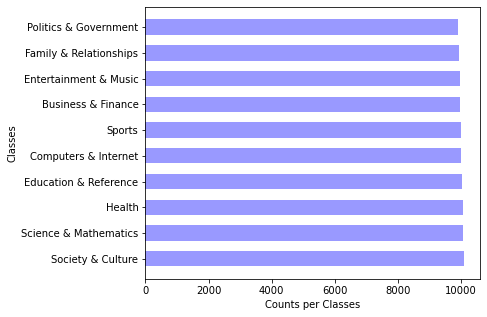

In [11]:
fig,ax = plt.subplots(figsize=(6,5));
ax.barh(y = target_classes,width=df.target.value_counts().values,color='b',alpha=0.4,height=0.6);
ax.set_ylabel('Classes');
ax.set_xlabel('Counts per Classes');

In [12]:
# df['lang'] = df['Q&A'].apply(lambda x:langdetect.detect(x) if x.strip()!="" else "")

In [13]:
lst_stopwords = stopwords.words('english')

In [14]:
def text_cleaning(text,stem_flag=False,lem_flag=True,lst_stopwords=None):
    text = text.replace('\\n',' ')
    text = text.replace('\n',' ')
    text = re.sub(r'[^\w\s]',' ',str(text).lower().strip())
    lst_text = text.split()
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in lst_stopwords]
    if stem_flag == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
    if lem_flag == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
    lst_text = " ".join(lst_text)
    return lst_text

In [15]:
df['Text_new'] = df['Q&A'].apply(lambda x:text_cleaning(x,stem_flag=False,lem_flag=True,lst_stopwords=lst_stopwords))

In [16]:
df.head(10)

,target,question_title,question_content,best_answer,Q,Q&A,Text_new
1074171,6,where has todd bertuzzi from vancouver canucks...,,"After being banned from the NHL, he went over ...",where has todd bertuzzi from vancouver canucks...,where has todd bertuzzi from vancouver canucks...,todd bertuzzi vancouver canuck gone banned nhl...
6358,5,Can I burn .avi files to a DVDR on a regular c...,,I think you have answered your own question. I...,Can I burn .avi files to a DVDR on a regular c...,Can I burn .avi files to a DVDR on a regular c...,burn avi file dvdr regular cd drive dvd burner...
675440,6,Wonna buy a ticket to Cratia-Japan?,,Even if I had money to buy the ticket I wouldn...,Wonna buy a ticket to Cratia-Japan?,Wonna buy a ticket to Cratia-Japan?Even if I h...,wonna buy ticket cratia japan even money buy t...
395610,3,I have really bad tooth ache and my teeth are ...,My dentist really hates NHS Patients and treat...,"If you are not happy with your dentist, shop a...",I have really bad tooth ache and my teeth are ...,I have really bad tooth ache and my teeth are ...,really bad tooth ache teeth really sensitive p...
956133,2,what kinds of energy r there?,,"kinetic, gravitational, spring, electrical, ma...",what kinds of energy r there?,"what kinds of energy r there?kinetic, gravitat...",kind energy r kinetic gravitational spring ele...
797714,4,dose any one care about the nba payoffs beside...,,Mavericks Rule!!!!!!!!,dose any one care about the nba payoffs beside...,dose any one care about the nba payoffs beside...,dose one care nba payoff besides maverick rule
1025957,9,help!! did he cheat? or am i being paranoid?,me and my boyfriend broke up on halloween. we ...,"Okay,Okay.There is a lot of information here s...",help!! did he cheat? or am i being paranoid?me...,help!! did he cheat? or am i being paranoid?me...,help cheat paranoid boyfriend broke halloween ...
77232,7,how long must you wait after a Chapter 7 bankr...,,7 Years from the discharge of the one before. ...,how long must you wait after a Chapter 7 bankr...,how long must you wait after a Chapter 7 bankr...,long must wait chapter 7 bankruptcy file anoth...
978981,4,What is a Quiche Mam?,I already know it's some sort of god in Guatem...,"Here's what I could find, plus a link. I hope...",What is a Quiche Mam?I already know it's some ...,What is a Quiche Mam?I already know it's some ...,quiche mam already know sort god guatemala thu...
148989,10,what happens if i marry a canadian?,can i just move to canada to be with wife? do ...,you may become a canadian citizen,what happens if i marry a canadian?can i just ...,what happens if i marry a canadian?can i just ...,happens marry canadian move canada wife become...


In [17]:
df['word_count'] = df['Q&A'].apply(lambda x:len(str(x).split(" ")))
df['char_count'] = df['Q&A'].apply(lambda x: sum(len(word)for word in str(x).split(" ")))
df['sentence_count'] = df['Q&A'].apply(lambda x:len(str(x).split(".")))
df['word_length'] = df['char_count']/df['word_count']
df['word_per_sentence'] = df['word_count']/df['sentence_count']

In [18]:
df.head(2)

,target,question_title,question_content,best_answer,Q,Q&A,Text_new,word_count,char_count,sentence_count,word_length,word_per_sentence
1074171,6,where has todd bertuzzi from vancouver canucks...,,"After being banned from the NHL, he went over ...",where has todd bertuzzi from vancouver canucks...,where has todd bertuzzi from vancouver canucks...,todd bertuzzi vancouver canuck gone banned nhl...,43,200,4,4.651163,10.750000
6358,5,Can I burn .avi files to a DVDR on a regular c...,,I think you have answered your own question. I...,Can I burn .avi files to a DVDR on a regular c...,Can I burn .avi files to a DVDR on a regular c...,burn avi file dvdr regular cd drive dvd burner...,81,313,7,3.864198,11.571429


In [19]:
colors=['b','g','r','k','magenta','orange','aqua','violet','peachpuff','pink']
len(colors)

10

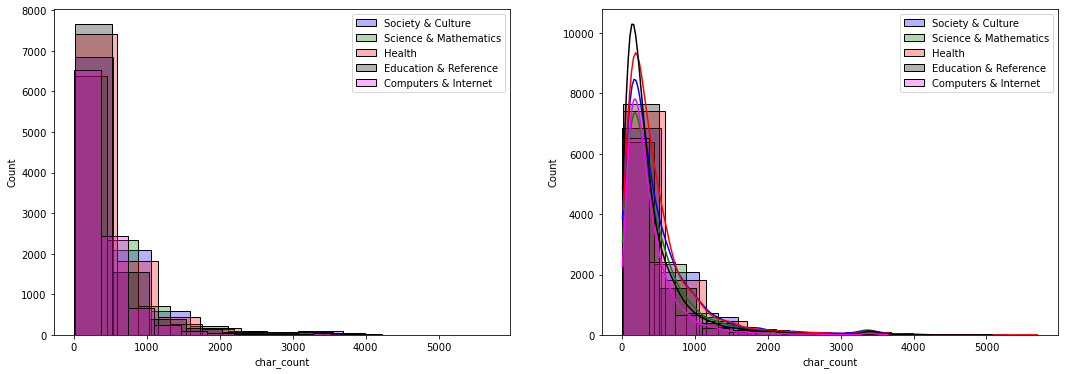

In [20]:
plt_list = ['word_count','char_count','sentence_count','word_length','word_per_sentence']
fig,ax = plt.subplots(1,2,figsize=(18,6))
for i in range(5):#df.target.unique():
    sns.histplot(df[df.target==i+1][plt_list[1]],kde=False,bins=10,ax=ax[0],alpha=0.3,color=colors[i],label=target_classes[i]);
    sns.histplot(df[df.target==i+1][plt_list[1]],kde=True,bins=10,ax=ax[1],alpha=0.3,color=colors[i],label=target_classes[i]);
ax[0].legend();
ax[1].legend();
plt.show();

In [21]:
df.groupby('target').word_count.median()

target
1     72
2     67
3     75
4     52
5     58
6     45
7     53
8     41
9     76
10    73
Name: word_count, dtype: int64

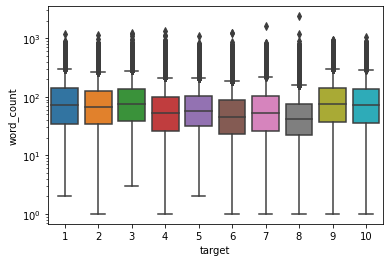

In [22]:
ax = sns.boxplot(x="target", y="word_count", data=df)
ax.set_yscale('log')

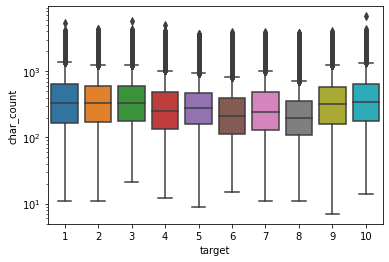

In [23]:
ax = sns.boxplot(x="target", y="char_count", data=df)
ax.set_yscale('log')

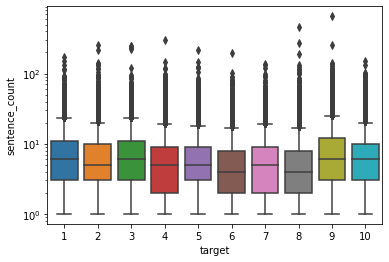

In [24]:
ax = sns.boxplot(x="target", y="sentence_count", data=df)
ax.set_yscale('log')

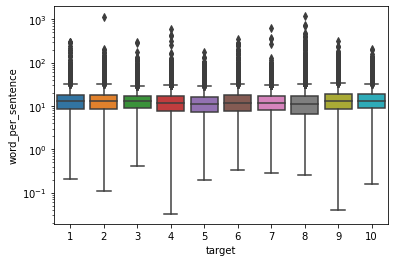

In [25]:
ax = sns.boxplot(x="target", y="word_per_sentence", data=df)
ax.set_yscale('log')

### Tf-idf Method for text classification

In [26]:
X = df.Text_new
y = df.target

In [27]:
X_train,X_test,y_train,y_test = train_test_split(X,y,stratify=y,test_size=0.1,random_state=20)

In [28]:
vect = TfidfVectorizer(max_features=10000,ngram_range=(1,2))

In [29]:
vect.fit(X_train)

TfidfVectorizer(max_features=10000, ngram_range=(1, 2))

In [30]:
# X_train is the raw data
# XX_train is the matrix based on the X_train
XX_train = vect.transform(X_train)

In [31]:
vocab = vect.vocabulary_

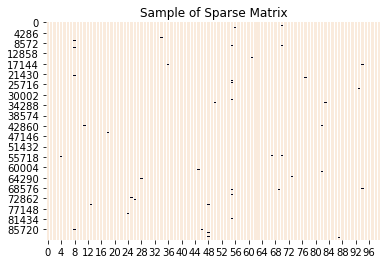

In [32]:
sns.heatmap(XX_train.todense()[:,np.random.randint(0,XX_train.shape[1],100)]==0 , vmin=0 , vmax=1,cbar=False).set_title('Sample of Sparse Matrix');

In [33]:
X_names = vect.get_feature_names()
df_features = pd.DataFrame()
for category in np.unique(y_train):
    chi2,p = feature_selection.chi2(XX_train,y_train==category)
    df_features = df_features.append(pd.DataFrame({'feature':X_names,'Score':1-p,"y":category}))
    df_features = df_features.sort_values(["y","Score"],ascending=[True,False])
    df_features = df_features[df_features.Score>0.95]

X_names_unique = df_features.feature.unique().tolist()

In [34]:
df_features.head(5)

,feature,Score,y
489,allah,1.0,1
838,atheist,1.0,1
1044,belief,1.0,1
1045,believe,1.0,1
1046,believe god,1.0,1


In [94]:
for category in np.unique(y_train):
    print(f'category {category}:',target_classes[category-1])
    print(f'length of category {category}:',len(df_features[df_features.y==category]))
    print(",".join(df_features[df_features.y==category].feature[:20]))
    print("")

category 1: Society & Culture
length of category 1: 1237
allah,atheist,belief,believe,believe god,believer,bible,bible say,catholic,catholic church,christ,christian,christianity,christmas,church,commandment,culture,eternal,eve,evil

category 2: Science & Mathematics
length of category 2: 1931
2x,2y,3x,4x,5x,6x,acceleration,acid,air,amino,angle,angular,animal,aq,asteroid,atmosphere,atom,atomic,axis,big bang

category 3: Health
length of category 3: 1860
ab,abdomen,abdominal,ache,acne,allergic,allergy,antibiotic,anxiety,appetite,arthritis,ask doctor,asthma,bacteria,bipolar,birth control,bladder,bleeding,blood,blood pressure

category 4: Education & Reference
length of category 4: 868
admission,book,class,classroom,college,degree,dictionary,diploma,edu,education,english,essay,exam,financial aid,gpa,grade,graduate,grammar,high school,homework

category 5: Computers & Internet
length of category 5: 1907
92,access,account,adapter,add,add remove,address,address bar,administrator,adobe,adware,

In [62]:
vect = TfidfVectorizer(vocabulary=X_names_unique)

In [63]:
vect.fit(X_train)

TfidfVectorizer(vocabulary=['allah', 'atheist', 'belief', 'believe',
                            'believe god', 'believer', 'bible', 'bible say',
                            'catholic', 'catholic church', 'christ',
                            'christian', 'christianity', 'christmas', 'church',
                            'commandment', 'culture', 'eternal', 'eve', 'evil',
                            'faith', 'follower', 'forgiveness', 'gay', 'gift',
                            'god', 'god god', 'gospel', 'heaven', 'hell', ...])

In [64]:
# X_train is the raw data
# XX_train is the matrix based on the X_train
XX_train = vect.transform(X_train)

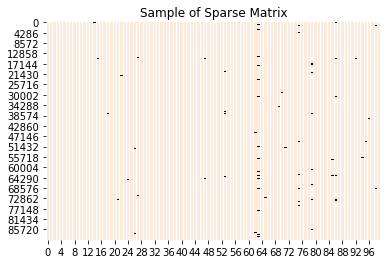

In [66]:
sns.heatmap(XX_train.todense()[:,np.random.randint(0,XX_train.shape[1],100)]==0 , vmin=0 , vmax=1,cbar=False).set_title('Sample of Sparse Matrix');

In [68]:
# Creating a cloud of words

In [140]:
def plot_cloud(wordcloud):
    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud)
    plt.axis('off')

In [195]:
Text = " ".join(df_features[df_features.y==7].feature[:20])
Text

'account accounting asset bad credit bank bankruptcy broker business business plan buyer card cash company credit credit card credit report credit score creditor currency customer'

In [196]:
wordcloud = WordCloud(width=1000,height=880,random_state=1,background_color='black',colormap='Set2',
                      collocations=False,stopwords=lst_stopwords).generate(Text)

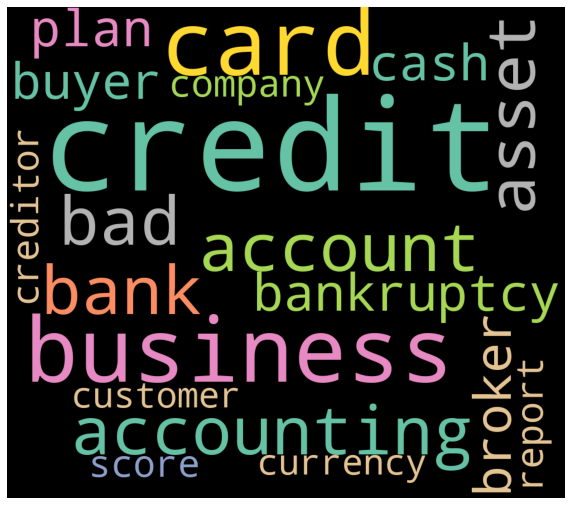

In [197]:
plot_cloud(wordcloud)

### Naive Bayes Classifier
In this section, we used Naive bayes classifer to fit our model to training data

In [151]:
nb = naive_bayes.MultinomialNB()

In [152]:
# pipeline
model = pipeline.Pipeline([("vectorizer",vect),
                           ("classifier",nb)])

In [153]:
cross_val_score(model,X_train,y_train,cv=5,n_jobs=-1)

array([0.67138889, 0.67527778, 0.67511111, 0.67111111, 0.67183333])

In [154]:
# Train Classifier
#model['classifier'].fit(XX_train,y_train)
model.fit(X_train,y_train)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(vocabulary=['allah', 'atheist', 'belief',
                                             'believe', 'believe god',
                                             'believer', 'bible', 'bible say',
                                             'catholic', 'catholic church',
                                             'christ', 'christian',
                                             'christianity', 'christmas',
                                             'church', 'commandment', 'culture',
                                             'eternal', 'eve', 'evil', 'faith',
                                             'follower', 'forgiveness', 'gay',
                                             'gift', 'god', 'god god', 'gospel',
                                             'heaven', 'hell', ...])),
                ('classifier', MultinomialNB())])

In [155]:
## Test Classifier
Predicted = model.predict(X_test)
Predicted_prob = model.predict_proba(X_test)

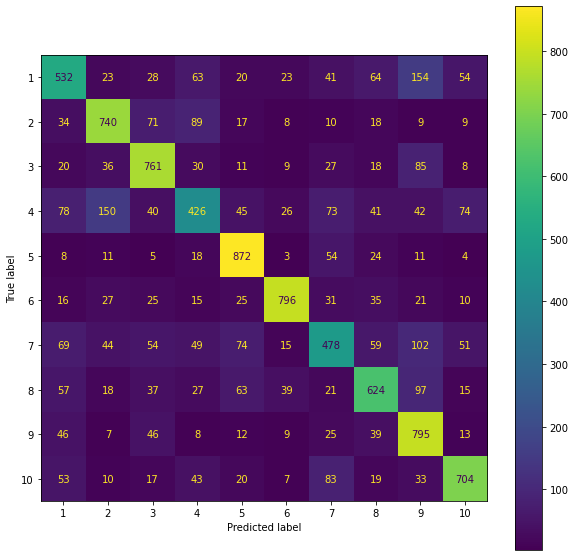

In [51]:
fig, ax = plt.subplots(figsize=(10, 10));
plot_confusion_matrix(model,X_test,y_test,ax=ax);

### Logistic Regression Classifier
In this section, we used logistic classifer to fit our model to training data

In [52]:
lr = LogisticRegression(max_iter=5000)

In [53]:
# pipeline
model_lr = pipeline.Pipeline([("vectorizer",vect),
                           ("classifier",lr)])

In [54]:
cross_val_score(model_lr,X_train,y_train,cv=5,n_jobs=-1)

array([0.67927778, 0.67711111, 0.679     , 0.67738889, 0.68061111])

In [55]:
# Train Classifier
#model['classifier'].fit(XX_train,y_train)
model_lr.fit(X_train,y_train)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_features=10000, ngram_range=(1, 2))),
                ('classifier', LogisticRegression(max_iter=5000))])

In [56]:
## Test Classifier
Predicted = model_lr.predict(X_test)
Predicted_prob = model_lr.predict_proba(X_test)

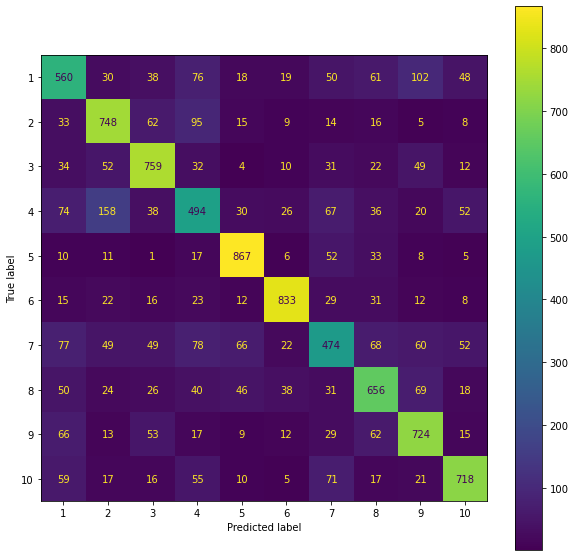

In [57]:
fig, ax = plt.subplots(figsize=(10, 10));
plot_confusion_matrix(model_lr,X_test,y_test,ax=ax);

### Random Forest Classifier
In this section, we will use random forest classiier to fit our model to the training dataset

In [69]:
rf = RandomForestClassifier(n_jobs=-1)

In [70]:
# pipeline
model_rf = pipeline.Pipeline([("vectorizer",vect),
                              ("classifier",rf)])

In [71]:
cross_val_score(model_rf,X_train,y_train,cv=5,n_jobs=3)

array([0.609     , 0.60311111, 0.60805556, 0.60505556, 0.61272222])

In [169]:
classes = np.unique(y_test)
y_test_dummy = pd.get_dummies(y_test).values

accuracy = accuracy_score(y_test,Predicted)
auc = roc_auc_score(y_test,Predicted_prob,multi_class='ovr')

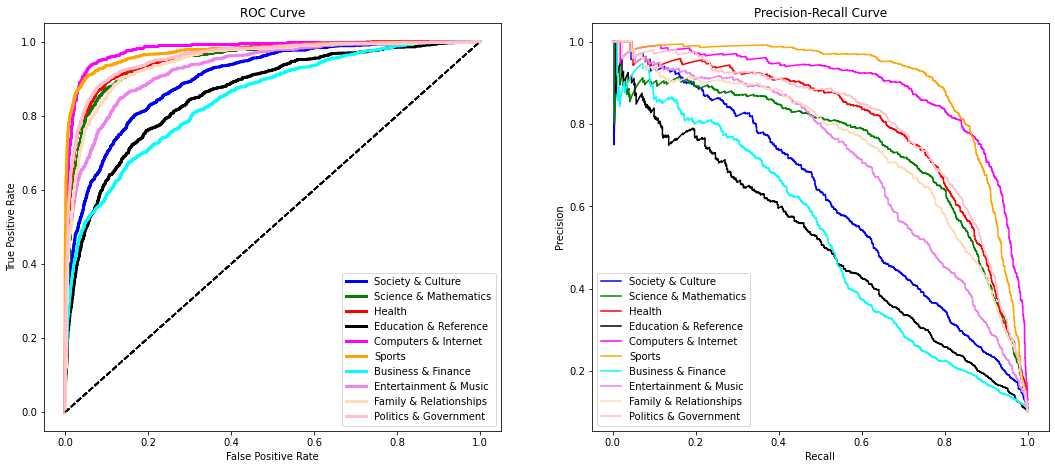

In [194]:
fig,axs = plt.subplots(1,2,figsize=(18,7.5))
for i in range(10):
    # ROC Curve
    fpr,tpr,thresholds = roc_curve(y_test_dummy[:,i],Predicted_prob[:,i])
    axs[0].plot(fpr,tpr,lw=3,label=target_classes[i],color=colors[i])
    axs[0].plot([0,1],[0,1],color='k',ls='--')
    axs[0].set_xlabel('False Positive Rate')
    axs[0].set_ylabel('True Positive Rate')
    axs[0].legend()
    axs[0].set_title('ROC Curve')
    # Precision-Recall Curve
    precision,recall,thresholds = precision_recall_curve(y_test_dummy[:,i],Predicted_prob[:,i])
    axs[1].plot(recall,precision,label=target_classes[i],color=colors[i])
    axs[1].set_xlabel('Recall')
    axs[1].set_ylabel('Precision')
    axs[1].set_title('Precision-Recall Curve')
    axs[1].legend()
    

In [226]:
# Testing the error
# X_test[y_test!=Predicted].iloc[1]
# y_test[y_test!=Predicted]
# Predicted[y_test!=Predicted]


In [ ]:
explainer = lime_text.LimeTextExplainer()

In [ ]:
# vectorizer = TfidfVectorizer(stop_words=lst_stopwords,min_df=5,max_features=5000)

In [ ]:
# vec_df = vectorizer.fit_transform(df['Q&A'])

In [ ]:
# features_name = vectorizer.get_feature_names()

In [ ]:
# X_vec = vec_df
# A = np.squeeze(np.asarray(X_vec.sum(axis=0)))
# A = pd.Series(A)

In [ ]:
# v =  A.sort_values(ascending=False)[:20]
# top_words_index = A.sort_values(ascending=False).index[:20]
# top_words_index

In [ ]:
# top_words=[]
# for i in top_words_index:
#     top_words.append(features_name[i])
    
# top_words